In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

In [9]:
test_dataset = datasets.ImageFolder(root='../../main_dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc4 = nn.Linear(hidden_dim//2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim//2)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)  

        x = self.fc2(x)
        x = self.batchnorm1(x)  
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.batchnorm2(x) 
        x = self.relu(x)
        x = self.dropout(x) 
        
        x = self.fc4(x)
        
        return x


In [11]:
model = timm.create_model('mobilevitv2_075.cvnets_in1k', pretrained=True)
num_classes = len(test_dataset.classes)

model.head.fc = MLP(model.head.fc.in_features, 512, num_classes)

model.load_state_dict(torch.load('./models/last.pt'))


<All keys matched successfully>

In [12]:
from sklearn.metrics import accuracy_score
# Generating predictions for the test dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
class_names = test_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
print(f'test_accuracy:{accuracy_score(all_labels, all_preds)}%')

test_accuracy:0.9972785001511945%


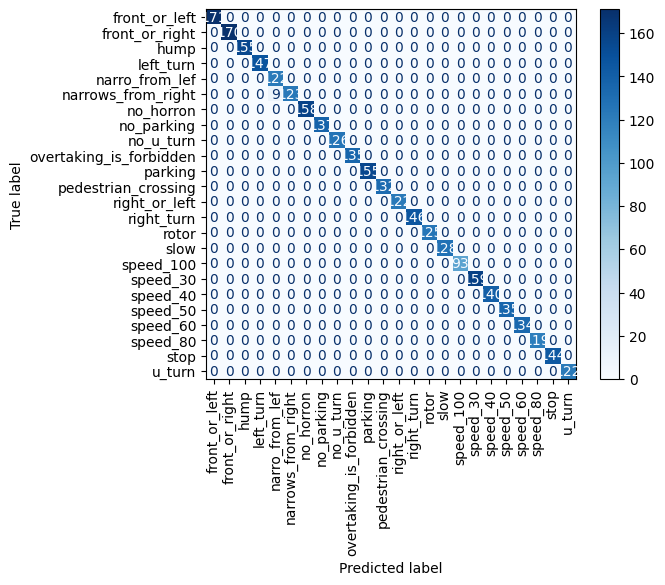

In [13]:
# Plotting the confusion matrix and rotating the x-axis labels , make the numbers more readable.
disp.plot(xticks_rotation='vertical', cmap=plt.cm.Blues)
# color blues



plt.show()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor